In [5]:
# Portfolio Optimisation

# Importing all required libraries
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [6]:
# Importing the Portfolio Optimisation Library functions
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

In [29]:
# Get tickers of required stocks
# Using Nestle, Roche, Swisscom, Swiss Re, BCV, 
tickers = ["NESN.SW", "ROG.SW", "SCMN.SW", "SREN.SW", "BCVN.SW", "KER.PA"]
the_len = len(tickers)
price_data = []

for ticker in range(the_len):
    prices = web.DataReader(tickers[ticker], start="2015-01-01", end="2021-03-12", data_source="yahoo")
    price_data.append(prices.assign(ticker=ticker)[["Adj Close"]])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.head()

,NESN.SW,ROG.SW,SCMN.SW,SREN.SW,BCVN.SW,KER.PA
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,126.598030
2015-01-05,60.324280,226.577774,392.545959,59.720718,45.086746,123.708931
2015-01-06,59.904190,225.343231,384.495697,59.250484,45.044849,122.545258
2015-01-07,60.114235,225.343231,389.862549,59.467514,45.673382,124.591721
2015-01-08,61.206455,232.091995,396.762756,60.914413,45.212460,128.443817


In [30]:
# Checking if there are any NAN values in the data
nullin_df = pd.DataFrame(df_stocks, columns=tickers)
print(nullin_df.isnull().sum())

NESN.SW    29
ROG.SW     29
SCMN.SW    29
SREN.SW    29
BCVN.SW    29
KER.PA      0
dtype: int64


In [31]:
# Annualised Return
mu = expected_returns.mean_historical_return(df_stocks)

mu

NESN.SW    0.083787
ROG.SW     0.048179
SCMN.SW    0.032263
SREN.SW    0.071246
BCVN.SW    0.125591
KER.PA     0.279634
dtype: float64

In [32]:
# Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

Sigma

,NESN.SW,ROG.SW,SCMN.SW,SREN.SW,BCVN.SW,KER.PA
NESN.SW,0.026976,0.020654,0.016032,0.016402,0.010390,0.019000
ROG.SW,0.020654,0.039843,0.017148,0.019480,0.011238,0.019811
SCMN.SW,0.016032,0.017148,0.027948,0.019056,0.012004,0.018755
SREN.SW,0.016402,0.019480,0.019056,0.055827,0.018135,0.035675
BCVN.SW,0.010390,0.011238,0.012004,0.018135,0.027234,0.018789
KER.PA,0.019000,0.019811,0.018755,0.035675,0.018789,0.094711


In [33]:
# Max Sharpe Ratio - Tangent to the EF
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))  # weight_bounds in negative allows shorting of stocks
sharpe_pfolio = ef1.max_sharpe()  # May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt = ef1.clean_weights()
print(sharpe_pwt)

OrderedDict([('NESN.SW', 0.0), ('ROG.SW', 0.0), ('SCMN.SW', 0.0), ('SREN.SW', 0.0), ('BCVN.SW', 0.50173), ('KER.PA', 0.49827)])


In [34]:
# Get portfolio performance
ef1.portfolio_performance(verbose=True)  # 2 year risk free rate - Treasury Yield would set risk_free_rate=0.27

Expected annual return: 20.2%
Annual volatility: 19.9%
Sharpe Ratio: 0.91


(0.20234576982437685, 0.19941009128941076, 0.9144259884006178)

In [35]:
# Minimum Volatility Portfolio
ef2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))  # weight_bounds in negative allows shorting of stocks
minvol = ef2.min_volatility()
minvol_pwt = ef2.clean_weights()
print(minvol_pwt)

OrderedDict([('NESN.SW', 0.29972), ('ROG.SW', 0.06739), ('SCMN.SW', 0.24218), ('SREN.SW', 0.0), ('BCVN.SW', 0.39071), ('KER.PA', 0.0)])


In [36]:
# Get MinVol portfolio performance
ef2.portfolio_performance(verbose=True)  # 2 year risk free rate - Treasury Yield would set risk_free_rate=0.27

Expected annual return: 8.5%
Annual volatility: 13.2%
Sharpe Ratio: 0.49


(0.08524270642880272, 0.13198112466373, 0.4943336147121968)

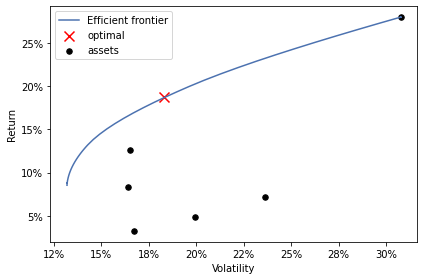

In [37]:
# Plot the Efficient Frontier for visual puposes
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.0%}".format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))

In [38]:
# Get latest prices
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
latest_prices

NESN.SW    100.000000
ROG.SW     304.500000
SCMN.SW    479.200012
SREN.SW     92.019997
BCVN.SW     94.800003
KER.PA     596.400024
Name: 2021-03-12 00:00:00, dtype: float64

In [39]:
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy

# Max Sharpe Ratio Portfolio Allocation $10,000
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio()
print(allocation_shp)
print("Leftover fund after building Max Sharpe Portfolio is ${:.2f}".format(rem_shp))

{'BCVN.SW': 53, 'KER.PA': 8}
Leftover fund after building Max Sharpe Portfolio is $204.40


In [40]:
# Min Volatility Portfolio Allocation $10,000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol, latest_prices, total_portfolio_value=10000).lp_portfolio()
print(allocation_minv)
print("Leftover fund after building Min Volatility Portfolio is ${:.2f}".format(rem_minv))

{'NESN.SW': 30, 'ROG.SW': 2, 'SCMN.SW': 5, 'BCVN.SW': 42}
Leftover fund after building Min Volatility Portfolio is $13.40
